# Окна и сглаживания

В этом ноутбуке попробуем генерить последовательность, а затем оставлять только определенные интервалы.

In [1]:
# imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

In [2]:
import pandas as pd
# load data
tmp_data = np.array(pd.read_csv('omni2_daily_eHiYe82FKM.lst', sep='\s+'))
print(tmp_data[:10, :])
print(tmp_data.shape)

data = pd.DataFrame(tmp_data, columns=['Year', 'Day', 'Hour', 'B', 'Kp', 'R', 'Dst', 'ap', 'F10.7', 'AE', 'AL', 'AU', 'pc', 'Lyman-alpha'])
data.head()
N = data['Dst'].size

[[ 1.9650e+03  2.0000e+00  0.0000e+00  9.9990e+02  2.3000e+01  3.7000e+01
   1.1000e+01  1.1000e+01  8.1500e+01  1.4700e+02  9.9999e+04  9.9999e+04
   9.9990e+02  6.2620e-03]
 [ 1.9650e+03  3.0000e+00  0.0000e+00  9.9990e+02  1.3000e+01  4.4000e+01
   4.0000e+00  7.0000e+00  7.9400e+01  6.9000e+01  9.9999e+04  9.9999e+04
   9.9990e+02  6.2620e-03]
 [ 1.9650e+03  4.0000e+00  0.0000e+00  9.9990e+02  1.0000e+01  4.4000e+01
   1.2000e+01  4.0000e+00  7.8000e+01  8.6000e+01  9.9999e+04  9.9999e+04
   9.9990e+02  6.2270e-03]
 [ 1.9650e+03  5.0000e+00  0.0000e+00  9.9990e+02  7.0000e+00  3.7000e+01
   7.0000e+00  2.0000e+00  7.7400e+01  4.4000e+01  9.9999e+04  9.9999e+04
   9.9990e+02  6.2620e-03]
 [ 1.9650e+03  6.0000e+00  0.0000e+00  9.9990e+02  3.0000e+00  2.8000e+01
   1.1000e+01  2.0000e+00  7.7700e+01  3.3000e+01  9.9999e+04  9.9999e+04
   9.9990e+02  6.2620e-03]
 [ 1.9650e+03  7.0000e+00  0.0000e+00  9.9990e+02  1.3000e+01  2.6000e+01
   1.3000e+01  4.0000e+00  7.5700e+01  5.5000e+01  

In [3]:
# set random generator
generator = np.random.RandomState(42)

# settings of graphics
width = 17
height = 5
matplotlib.rcParams['figure.figsize'] = [width, height]
matplotlib.rcParams['lines.markersize'] = 0.5
matplotlib.rcParams['scatter.edgecolors'] = "black"

# autoregression generator
# p               memory parameter of autoregression, 0 <= p <= 1
# base_value      first value, from which the generation is initialized
# noise_maker     function of time which produces noise
# to_add          number of elements in result
def ar(p, base_value, noise_maker, to_add = 10000):
    new_vals = np.array(arr)
    new_vals = np.append(new_vals, [0] * to_add)
    pos = 1
    for i in range(to_add):
        noise = noise_maker(i)
        new_vals[pos + i] = p * new_vals[pos + i - 1] + noise
    return new_vals

# fourier transform
# returns normalized amplitudes (scaled by the number of points)
# arr    input array
# draw   to draw or not to draw graphics of base data and amplitudes
# name   name of the feature
# x1     lower limit of periods to be displayed
# x2     upper limit of periods to be displayed
# y      upper limit of amplitudes to be displayed
def mfft2(arr, draw=False, name='a[n]', x1=0, x2=-1, y=0):
    if x2 == -1:
        x2 = len(arr) // 2 + 1
    plt.rcParams['axes.grid'] = True
    plt.tight_layout()
    A = np.fft.rfft((arr - np.mean(arr)) / len(arr))
    n = np.arange(len(arr))
    n1 = len(arr) / n[1:]
    if (draw):
        plt.rcParams['axes.grid'] = True
        fig, ax = plt.subplots(2, figsize=(6,4), dpi=150)
        plt.tight_layout()
        plt.subplots_adjust(hspace = 0.5)
        ax[0].plot(n, arr, '.-')
        ax[0].set_title(name)
        ax[0].set_ylim(-100, 100)
        ax[1].set_title('$A$')
        ax[1].set_xlim(x1, x2)
        ax[1].plot(n1[0 : (len(arr) // 2 + 1)], np.abs(A), '-')
        ax[1].set_xlabel('Период (в днях)')
        ax[1].set_ylabel('Амплитуда')
        if y != 0:
            ax[1].set_ylim(0, y)
        plt.show()
        
    return zip(n1[0 : (len(arr) // 2 + 1)], np.abs(A))

def mFFT(arr, draw = False, name='a[n]', x1 = 0, x2 = -1, y2 = -1, energy=False, norm = -1, smth = 0, silent=True):
    """
    Parameters
    ----------
    draw : bool
        Рисовать ли график
    name : str, optional
        Заголовок графика
    x1 : double, optional
        Левая граница по x на графике спектра
    x2 : double, optional
        Правая граница по x на графике спектра
    y2 : double, optional
        Верхняя граница по y на графике спектра
    smth : bool, optional
        Наличие сглаживания
    norm : double
        Число для нормировки, стандартное - длина массива
    energy : bool
        Искать ли энергию точки
    ep : double
        Точка для поиска энергии
    radius : double
        Радиус энергии
    silent : bool
        Нужен ли отладочный вывод
        
    Returns
    -------
    Если не выставлен флаг enerhy, то возвращается массив абсолютных значений амплитуд спектра.
    Если флаг выставлен, то возращается кортеж из четырех элементов - энергия амплитуды 27-дневного сигнала,
    энергия амплитуды полугодового сигнала, их отношение и массив абсолютных значений амплитуд сигнала.
    """
    if x2 == -1:
        x2 = len(arr) // 2
    if norm == -1:
        norm = len(arr)
        
    
    A = np.fft.rfft((arr - np.mean(arr)) / norm)
    
    if draw:
        
        plt.rcParams['axes.grid'] = True
        fig, ax = plt.subplots(2, figsize=(6,4), dpi=150)
        plt.tight_layout()
        
        n = np.arange(len(arr))
        n1 = len(arr) / n[1:]
        
        plt.subplots_adjust(hspace = 0.5)
        
        ax[0].plot(n, arr, '.-')
        ax[0].set_title(name) 
        
        ax[1].set_title('$A$')
        if y2 > 0:
            ax[1].set_ylim(0, y2)
        ax[1].set_xlim(x1, x2)
        if smth > 0:
            ax[1].plot(n1[0 : (len(arr) // 2 - 2 * smth + 1)], smoth(np.abs(A), smth), '-')
        else:
            ax[1].plot(n1[0 : (len(arr) // 2 + 1)], np.abs(A), '-')
        ax[1].set_xlabel('Период (в днях)')
        
        plt.show()
    
    if (energy):
        n = np.arange(len(arr))
        n1 = len(arr) / n[1:]
        
        ep = 29
        radius = 3
        
        msum = np.abs(A[(np.abs(n1[0 : (len(arr) // 2 + 1)] - ep) <= radius)]).sum()
        en1 = msum
        if not silent:
            print("Energy of", ep, "=", msum )
        
        ep = 183
        radius = 2
        
        msum = np.abs(A[(np.abs(n1[0 : (len(arr) // 2 + 1)] - ep) <= radius)]).sum()
        en2 = msum
        if not silent:
            print("Energy of", ep, "=", msum)
            print("Relation in", ep, "=", en1/en2)
        
        return en1, en2, en1/en2, np.abs(A)
    
    return (np.abs(A), n1)

In [4]:
# draws graphic of feature which is presented in table from omniweb and its mfft2 result
# name    name of the feature
# xlim    upper limit of periods
# ylim    upper limit of amplitudes
def draw_feature(name, xlim=100, ylim=0):
    if ylim == 0:
        mfft2(data[name], True, name, x1=0, x2=xlim)
    else:
        mfft2(data[name], True, name, x1=0, x2=xlim, y=ylim)

# draws some array and its mfft2
# name         name of the feature
# data_arr     input array for processing
# xlim         upper limit iot periods
# ylim         upper limit of periods
def draw_arr_feature(name, data_arr, xlim=100, ylim=0):
    if ylim == 0:
        mfft2(data_arr, True, name, x1=0, x2=xlim)
    else:
        mfft2(data_arr, True, name, x1=0, x2=xlim, y=ylim)

In [5]:
# checks if point x is in d-neighbourhood of center
spring = 79
autumn = 266

def in_delta(x, center, d):
    return np.abs(x - center) < d

def in_spring_delta(x, d):
    return in_delta(x, spring, d)

def in_autumn_delta(x, d):
    return in_delta(x, autumn, d)

In [6]:
# here is the variation of <<ar>> method,
# but the noise added in delta-neighbourhood of specific points differs
# from the noise in the rest of the area
# delta      the radius of sinusoidal noise area
# T          sinusoidal noise will have this period and cyclic frequency 2 * pi / T
# p          memory parametr in autoregression
# A_sin      amplitude of sinusoidal noise
# D_1        стандартное отклонение синусоидального шума
# B_2        среднее обычного шума
# D_2        стандартное отклонение обычного шума
def imitate_Dst(delta=45, T=27, p=1, A_sin=1, to_smooth=False, D_1=1, B_2=0, D_2=1, only_sin=False, A_sin2=1):
    freq = 2 * np.pi / T
    noiser_basic = lambda : generator.normal(B_2, D_2)
    noiser_sin = lambda i : generator.normal(A_sin * np.sin(freq * i), D_1)
    noiser_sin_small = lambda i : generator.normal(A_sin2 * np.sin(freq * i), D_2)
    start_value = -20
    arr = [start_value]
    for i in range(N):
        new_val = p * arr[-1]
        day = i % 365 + 1
        if in_spring_delta(day, delta) or in_autumn_delta(day, delta):
            # add noise_sin
            dval = noiser_sin(day)
            # if (i % 50 == 0):
                # print(dval)
            new_val += dval
        else:
            if only_sin:
                new_val += noiser_sin_small(day)
            else:
                # add noise_basic
                new_val += noiser_basic()
        arr.append(new_val)
    
    if to_smooth:
        mean_val = np.mean(arr)
        arr1 = []
        for i in range(len(arr)):
            day = i % 365 + 1
            if in_spring_delta(day, delta) or in_autumn_delta(day, delta):
                arr1.append(arr[i])
            else:
                arr1.append(mean_val)
        arr = arr1
    return arr

def smooth_feature(name="Dst", delta=45, xlim=360):
    N = data[name].size
    arr = np.array(data[name])
    mean_val = np.mean(data[name])
    narr = []
    for i in range(N):
        if in_spring_delta(data['Day'].iloc[i], delta) or in_autumn_delta(data['Day'].iloc[i], delta):
            narr.append(data[name].iloc[i])
        else:
            narr.append(mean_val)
    print('mean value =', mean_val)
    return mfft2(narr, draw=True, x2=xlim)

In [7]:
from sklearn.metrics import mean_absolute_error

# mp    current value of p
# left
# right frame where we count the amplitude
def get_amplitude_of_p(mp, left, right):
    generated_data = imitate_Dst(p=mp, A_sin=1)
    generated_data = list(map(lambda x : x, generated_data))
    fft_res = list(mfft2(generated_data, False, ""))
    filtered = filter(lambda x : left <= x[0] <= right, fft_res)
    return(max(map(lambda x : x[1], filtered)))

def get_semiannual_amp(mp):
    return get_amplitude_of_p(mp, 175, 190)

def get_27day_amp(mp):
    return get_amplitude_of_p(mp, 24, 30)

def draw_semiannual_amplitude(p_from=0.5, p_to=1, n=100):
    plt.figure(figsize=(13, 5))
    plt.xlabel("value of p", fontsize=17)
    plt.ylabel("amplitude of semi-annual period", fontsize=17)
    ps = np.linspace(p_from, p_to, n)
    res = list(map(lambda px : get_semiannual_amp(px), ps))
    plt.title("Dependency of A_semiannual from p", fontsize=19)
    plt.plot(ps, res)
    
def draw_27day_amplitude(p_from=0.5, p_to=1, n=100):
    plt.figure(figsize=(13, 5))
    plt.xlabel("value of p", fontsize=17)
    plt.ylabel("amplitude of 27-day period", fontsize=17)
    ps = np.linspace(p_from, p_to, n)
    res = list(map(lambda px : get_27day_amp(px), ps))
    approx_polynom = np.polyfit(ps, res, 1)
    approx = np.polyval(approx_polynom, ps)
    
    plt.title("Dependency of A_27day from p", fontsize=19)
    plt.plot(ps, res)
    plt.plot(ps, approx)
    print("polynomial : ", approx_polynom)
    
    mape = mean_absolute_error(res, approx) / sum(list(map(abs, res)))
    print("mean average error : ", mape)
    
def draw_amplitude_relation(p_from=0.5, p_to=1, n=100):
    plt.figure(figsize=(13, 5))
    plt.xlabel("value of p", fontsize=17)
    plt.ylabel("relation A_semi/A_27 ", fontsize=17)
    ps = np.linspace(p_from, p_to, n)
    res = list(map(lambda x : get_semiannual_amp(x) / max(0.01, get_27day_amp(x)), ps))
    plt.title("Dependency of amplitude relationship from p", fontsize=19)
    plt.plot(ps, res)

<Figure size 1224x360 with 0 Axes>

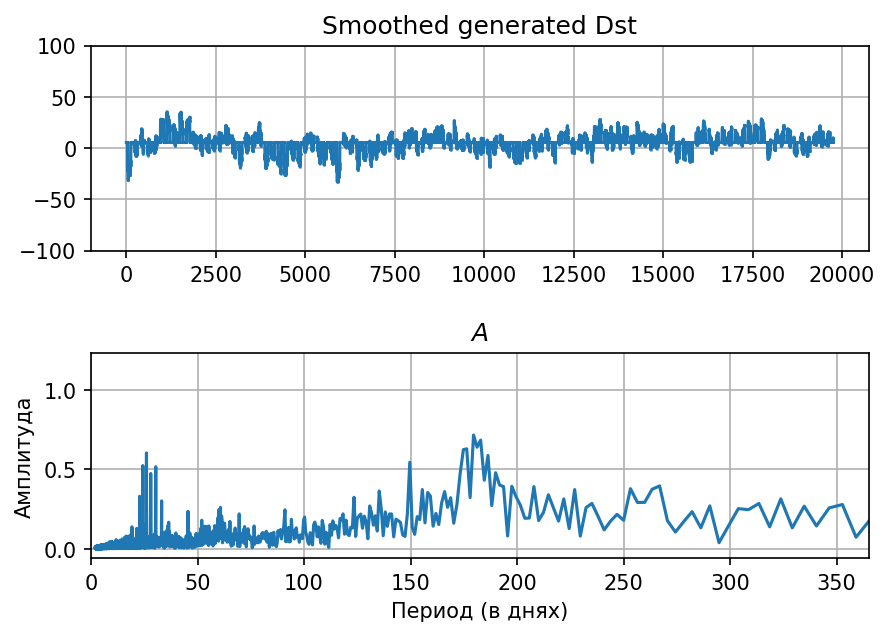

<Figure size 1224x360 with 0 Axes>

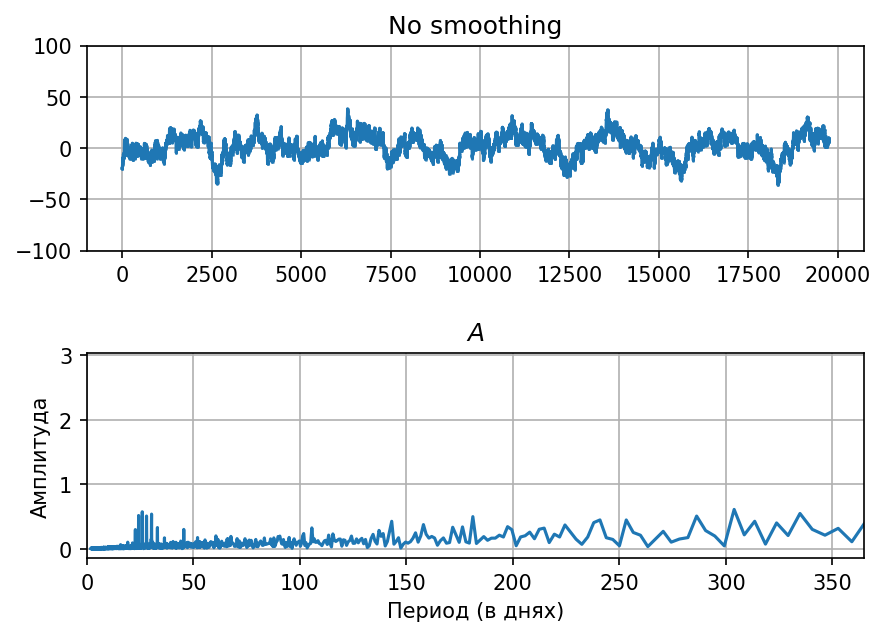

In [8]:
def action1():
    arr = imitate_Dst(p=0.995, to_smooth=True)
    mfft2(arr, draw=True, x2=365, name="Smoothed generated Dst")
    arr2 = imitate_Dst(p=0.995, to_smooth=False)
    mfft2(arr2, draw=True, x2=365, name="No smoothing")
action1()

<Figure size 1224x360 with 0 Axes>

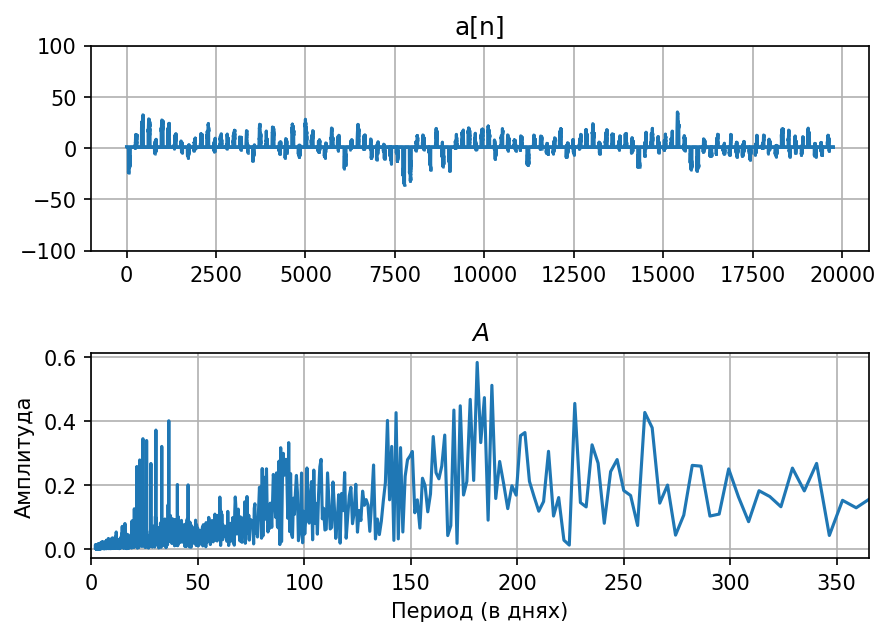

In [9]:
arr = imitate_Dst(p = 0.995, to_smooth=True, delta=27)
mfft2(arr, draw=True, x2=365)

Будем извлекать среднее значение амплитуд в $\varepsilon$-окрестности 27 дней и 183 дней. Судя по графикам для 27 дней следует взять $\varepsilon = 4$ (в днях). В следующей клетке - график для наглядности главного интервала частот.

<Figure size 1224x360 with 0 Axes>

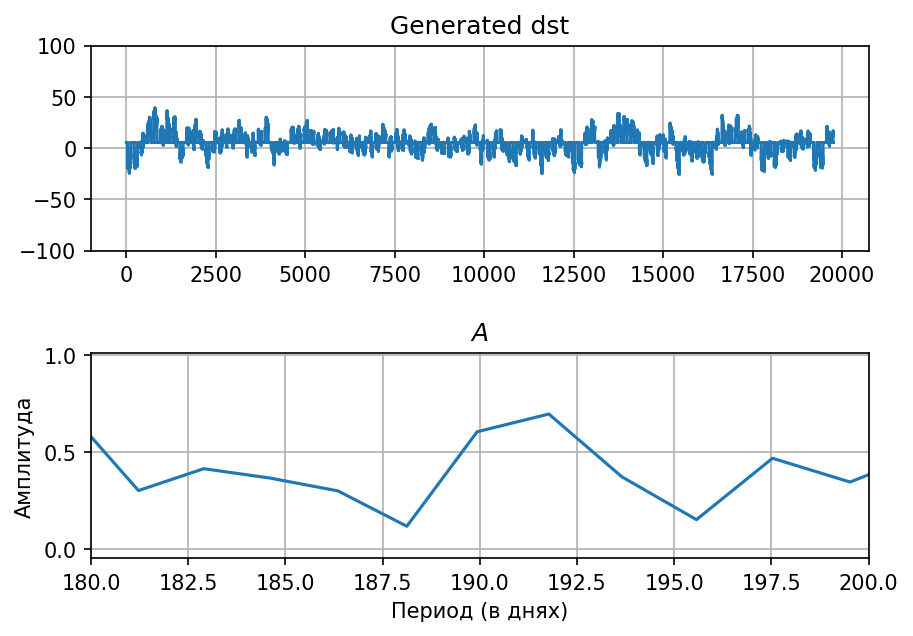

In [10]:
def action3():
    arr = imitate_Dst(p=0.995, to_smooth=True, B_2=0)
    mfft2(arr, draw=True, x1=180, x2=200, name="Generated dst")
action3()

In [11]:
def smooth_amps(t_from, t_to, amps):
    diap = list(filter(lambda x: t_from <= x[0] <= t_to, amps))
    ln = len(diap)
    return sum(map(lambda x : x[1], diap))

def smooth_27(amps):
    return smooth_amps(27 - 4, 27 + 4, amps)

def smooth_183(amps):
    return smooth_amps(183 - 4, 183 + 4, amps)

def smoothed_relation(amps):
    return smooth_27(amps) / max(0.1, smooth_183(amps))

<Figure size 1224x360 with 0 Axes>

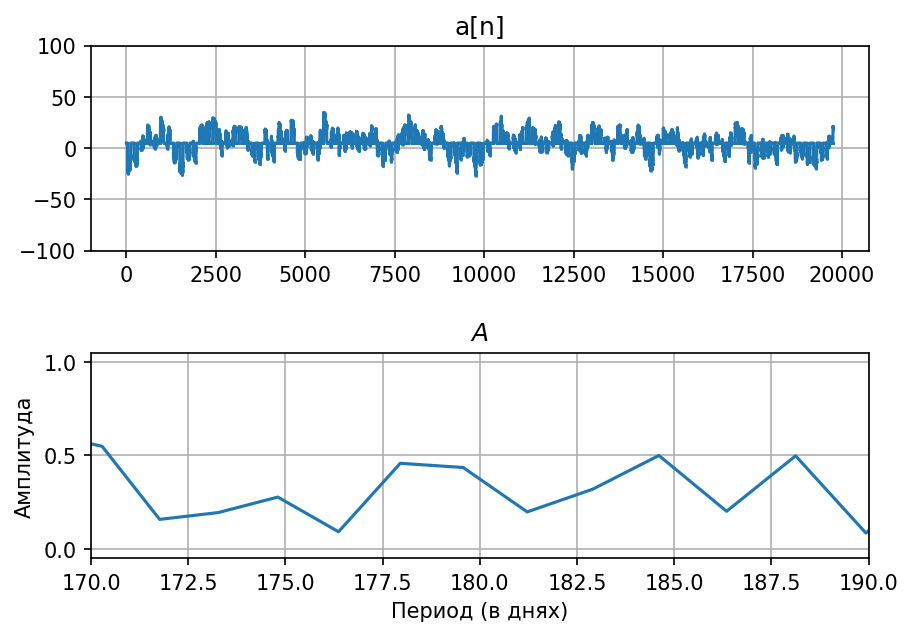

smoothed 27 :  11.993727177777348
smoothed 183:  1.651586478869505
relation    :  7.261943186884733


In [12]:
def action4():
    seq = imitate_Dst(p=0.995, to_smooth=True)
    res = list(mfft2(seq, draw=True, x1=170, x2=190))
    print("smoothed 27 : ", smooth_27(res))
    print("smoothed 183: ", smooth_183(res))
    print("relation    : ", smoothed_relation(res))
action4()

Ниже -- вычисление отношения амплитуд без сглаживания исходного графика

<Figure size 1224x360 with 0 Axes>

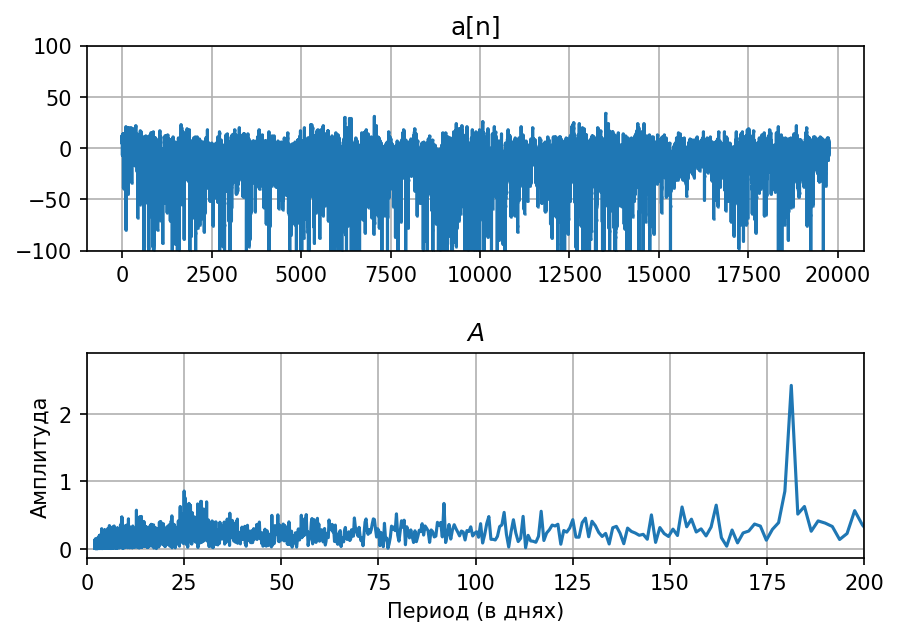

smoothed 27 :  59.872355062552096
smoothed 183:  4.681693742964012
relation    :  12.788609924032857


In [13]:
def action5():
    amps = list(mfft2(data['Dst'], draw=True, x1 = 0, x2 = 200))
    print("smoothed 27 : ", smooth_27(amps))
    print("smoothed 183: ", smooth_183(amps))
    print("relation    : ", smoothed_relation(amps))
action5()

Ниже -- то же самое вычисление, но исходный массив сглаживается вне равноденствий

mean value = -14.83834548400162


<Figure size 1224x360 with 0 Axes>

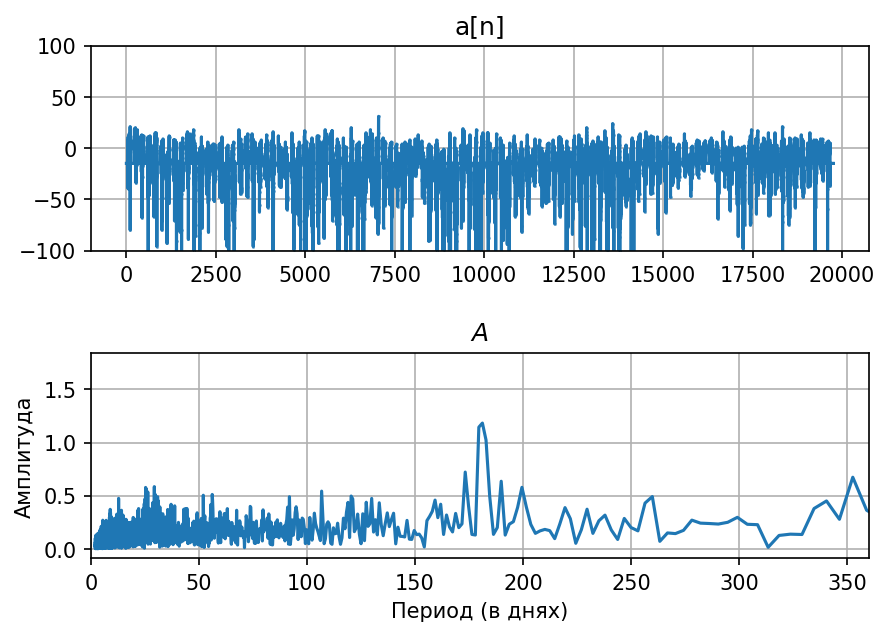

[(19752.0, 1.0512424264419451e-15), (9876.0, 1.7543322576012468), (6584.0, 0.22774155486669306), (4938.0, 0.0785539049954058), (3950.4, 0.34889585820003943), (3292.0, 1.0854966881783912), (2821.714285714286, 0.23344618750651927), (2469.0, 0.06599592957757475), (2194.6666666666665, 0.3359415638851413), (1975.2, 0.27651741251843365)]
smoothed 27 :  45.035868167084075
smoothed 183:  3.9814546448849892
relation    :  11.311410573254191


In [14]:
def action6():
    smoothed_dst = list(smooth_feature(name="Dst"))
    print(smoothed_dst[:10])
    print("smoothed 27 : ", smooth_27(smoothed_dst))
    print("smoothed 183: ", smooth_183(smoothed_dst))
    print("relation    : ", smoothed_relation(smoothed_dst))
action6()

In [15]:
def get_relation_of_p(mp, to_smooth=False):
    generated_data = imitate_Dst(p=mp, to_smooth=to_smooth)
    generated_data = list(map(lambda x : x, generated_data))
    fft_res = list(mfft2(arr=generated_data, draw=False, name=""))
    return(smoothed_relation(fft_res))

def draw_amplitude_relation(p_from=0.5, p_to=1, n=100, to_smooth=False):
    plt.figure(figsize=(13, 5))
    plt.xlabel("value of p", fontsize=17)
    plt.ylabel("relation A_27/A_semi ", fontsize=17)
    ps = np.linspace(p_from, p_to, n)
    res = list(map(lambda x : get_relation_of_p(x, to_smooth), ps))
    plt.title("Dependency of amplitude relationship from p", fontsize=19)
    plt.plot(ps, res)

График ниже получен следующим способом: брались сгенерированные без сглаживания последовательности для разных значений, после чего брались средние значения амплитуд на отрезках $[27-4, 27+4]$ и $[183-4, 183+4]$ спектра. После чего бралось отношение значения для 27 дней к значению 183 дней. 

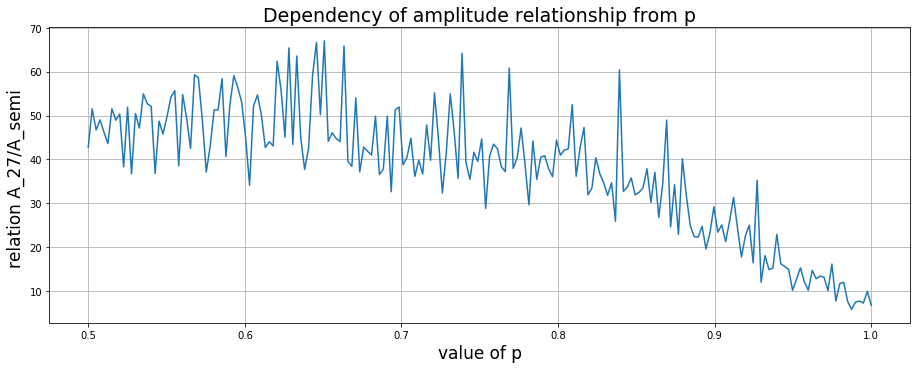

In [16]:
draw_amplitude_relation(n=200)

Различие между графиком сверху и графиком снизу заключается в том, что во втором случае добавлено сглаживание в генерацию.

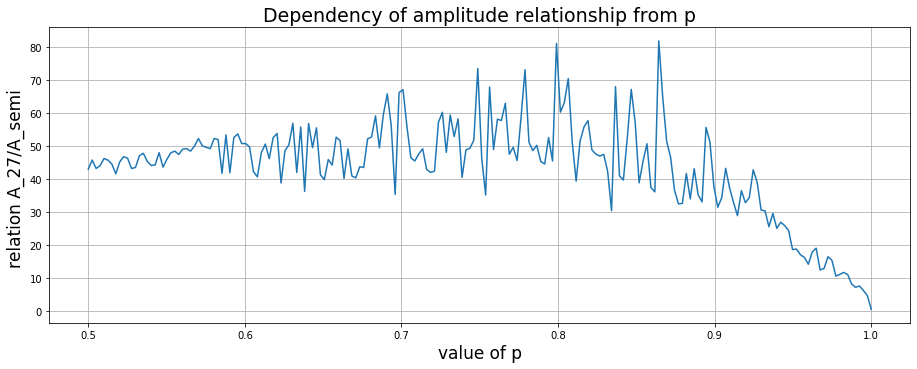

In [17]:
draw_amplitude_relation(n=200, to_smooth=True)

$x_t = px_{t-1} + \xi_t$

$\xi_t \sim N(sin(wt), D)$
---------------------------------

$x_t = px_{t-1} + \eta_t$

$\eta_t \sim N(0, D)$

$w = 2\pi / 27$

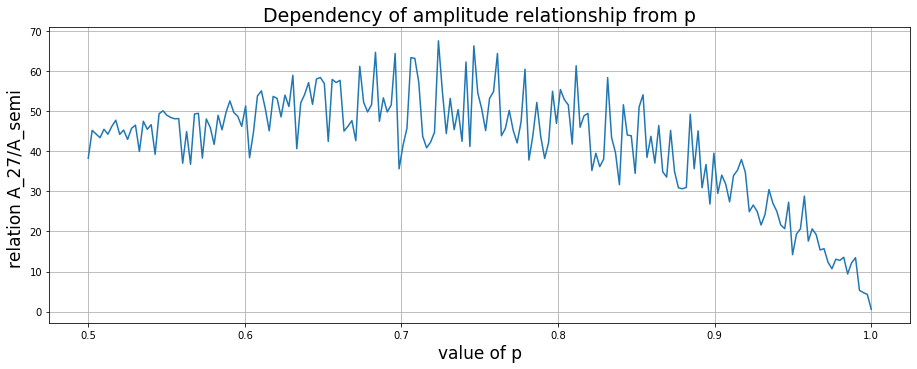

In [18]:
draw_amplitude_relation(n=200, to_smooth=True)

In [19]:
def filt(data, day, rad):
    data["filt"] = (((data["Day"] - day) % 365) <= rad) | ((data["Day"] - day) % 365 >= 365 - rad)
    data["filted"] = data["Dst"] * data["filt"] + (1 - data["filt"]) * data["Dst"].mean()

def filt_simple(data, day, rad):
    df = pd.DataFrame(data, columns=["Dst"])
    df['Day'] = np.arange(0, len(data))
    df["filt"] = (((df["Day"] - day) % 365) <= rad) | ((df["Day"] - day) % 365 >= 365 - rad)
    df["filted"] = df["Dst"] * df["filt"] + (1 - df["filt"]) * df["Dst"].mean()
    return df["filted"]
    
def get_year_max(datax, day, rad, year):
    datax["filt"] = (
        (abs(365 + datax["Day"] - day) % 365 <= rad)
        & (abs(datax['Year'] - year - 1965) < 1))
    return max(datax["Dst"] * datax["filt"])

## Подгон

Из данных знаем три параметра модели из пяти:
* $a \approx 19$ -- амплитуда синуса (??) 
* $D_2 \approx  19.1047597$ -- дисперсия обычного шума  $\eta$
* $b_2 \approx -12.2625514$ -- среднее обычного шума $\eta$
Предположение: возьмем данные по всем весенне-осенним пикам, для каждого года вычтем среднее значение на всем остальном промежутке. После этого возьмем среднее значение от максимумов. По идее должен выделиться максимум синуса, умноженного на амплитуду.

In [20]:
mx1 = 0
mx2 = 0

for i in range(55):
    dst1 = data.copy()
    dst2 = data.copy()
    mx1 += get_year_max(dst1, 79, 30, i)
    mx2 += get_year_max(dst2, 266, 30, i)
mx = (mx1 + mx2) / 110
print(mx, mx2, mx1)
mean_val = data["Dst"].mean()
print("mean = ", mean_val)
sin_amp = mx - mean_val
print("sinus amplitude =", sin_amp)

6.972727272727273 361.0 406.0
mean =  -14.83834548400162
sinus amplitude = 21.81107275672889


решим пока, что амплитуда синуса равна где-то $20$. Продублируем формулы с конкретными параметрами:
\begin{align}
& x_t = px_{t-1} + \xi_t, \quad t \in \left[79 - 30, 79 + 30\right] \cup [266 - 30, 266 + 30]\\
& x_t = px_{t - 1} + \eta_t, \ \ otherwise \\
& \xi_t \sim \mathcal{N}(20\sin (\omega t), D_1^2) , \quad \omega = \dfrac{2\pi}{27}\\
& \eta_t \sim \mathcal{N}(-12.2626, (19.1048)^2)\\
\end{align}

Перебор значений. Будем перебирать значения $p$ и $D_1$, для каждой комбинации генерировать последовательность. Затем находим параметры $b_2$ и $D_2$ (среднее значение и стандартное отклонение для обычного шума). Выбираем несколько лучших по сумме квадратов отклонений, строим их графики, смотрим глазами, что больше похоже на правду.

In [21]:
def get_ad_normal_noise(arr):
    dst1 = filt_simple(arr, 174, 45)
    dst2 = filt_simple(arr, 357, 45)
    a1 = dst1.mean()
    a2 = dst2.mean()
    d1 = dst1.std()
    d2 = dst2.std()
    return ((a1 + a2)/2, ((d1**2 + d2**2)**0.5) / 2)

def get_error(arr1, arr2):
    (a1, d1) = get_ad_normal_noise(arr1)
    (a2, d2) = get_ad_normal_noise(arr2)
    return (a1 - a2)**2 + (d1 - d2)**2

In [22]:
def get_errors(b_2=-12.2626,  d_2=19.1048, a_sin=20, delta=30):
    from sklearn.metrics import mean_squared_error
    ps = np.linspace(0.3, 1, 100) # p
    ds = np.linspace(0, 30, 70) # стандатное отклонение синуса
    results = []
    for p in ps:
        for d_1 in ds:
            gen_data = imitate_Dst(delta=delta, T=27, p=p, A_sin=a_sin, to_smooth=True, D_1=d_1, B_2=b_2, D_2=d_2)
            error = get_error(gen_data[1:], data['Dst'])
            results.append((p, d_1, error))
    return results

In [23]:
def get_top_errors(b_2=-12.2626,  d_2=19.1048, a_sin=20, delta=30):
    results = get_errors(b_2, d_2, a_sin, delta)
    top_results = sorted(results, key=lambda x: x[2])
    df_errors = pd.DataFrame(top_results, columns=["p", "D1", "error"])
    sorted_errors = df_errors.sort_values(by='error')
    sorted_errors.head
    return sorted_errors

In [24]:
top = get_top_errors()
top

,p,D1,error
0,0.568687,18.695652,2.361435e+01
1,0.533333,23.478261,2.366698e+01
2,0.575758,27.391304,2.385293e+01
3,0.582828,23.478261,2.386678e+01
4,0.561616,24.782609,2.388867e+01
...,...,...,...
6995,1.000000,6.086957,7.580185e+09
6996,1.000000,4.782609,7.589811e+09
6997,1.000000,3.478261,7.600635e+09
6998,1.000000,11.304348,7.616744e+09


## Графики для лучших значений

<Figure size 1224x360 with 0 Axes>

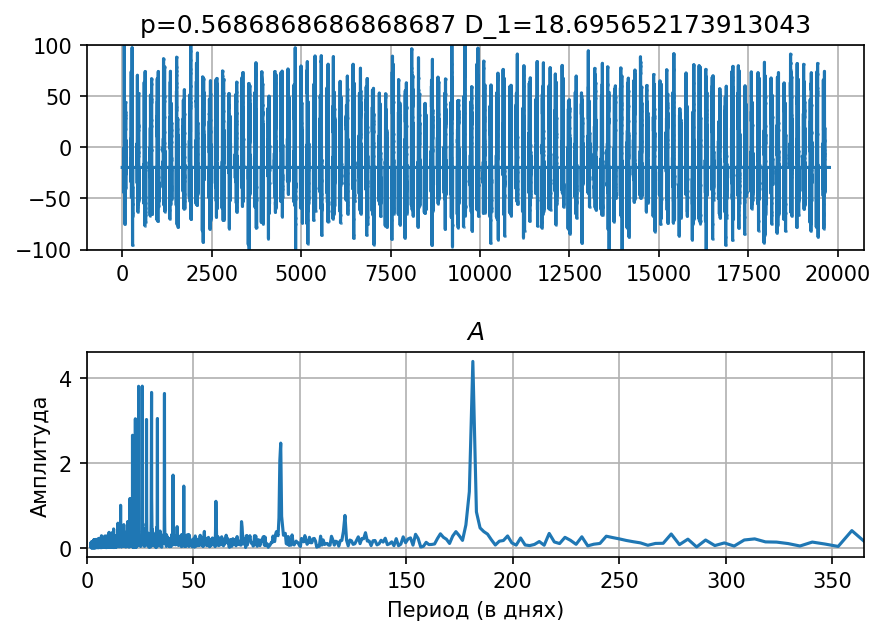

<Figure size 1224x360 with 0 Axes>

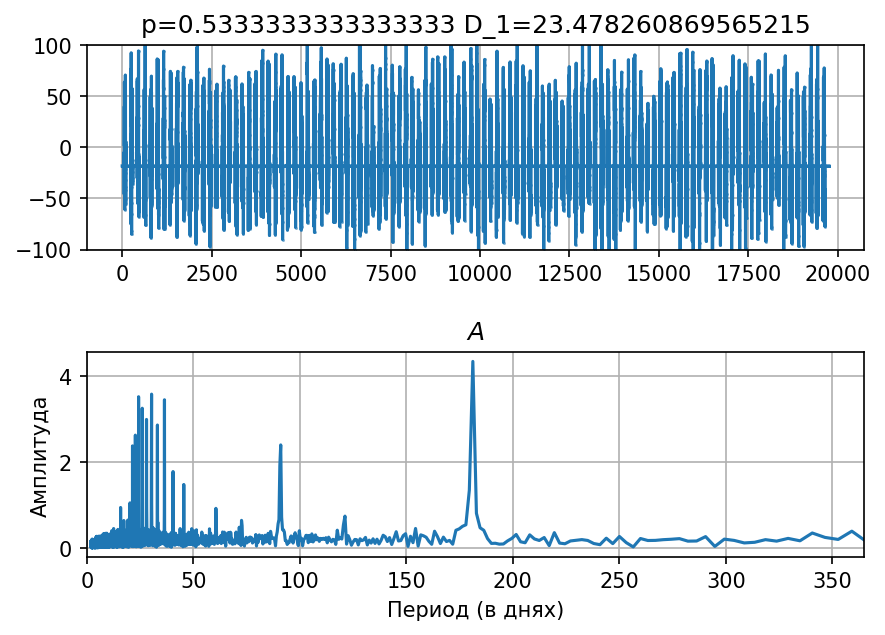

<Figure size 1224x360 with 0 Axes>

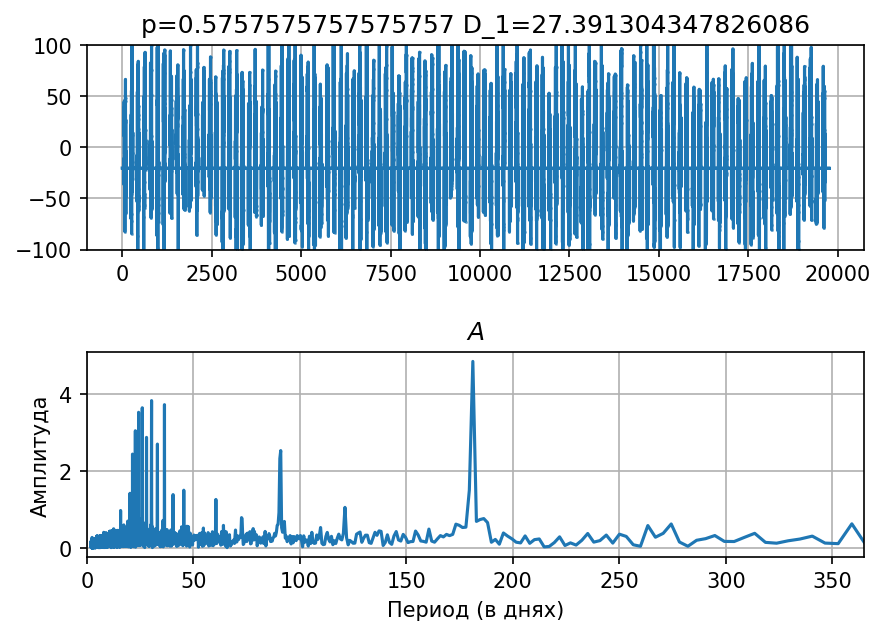

<Figure size 1224x360 with 0 Axes>

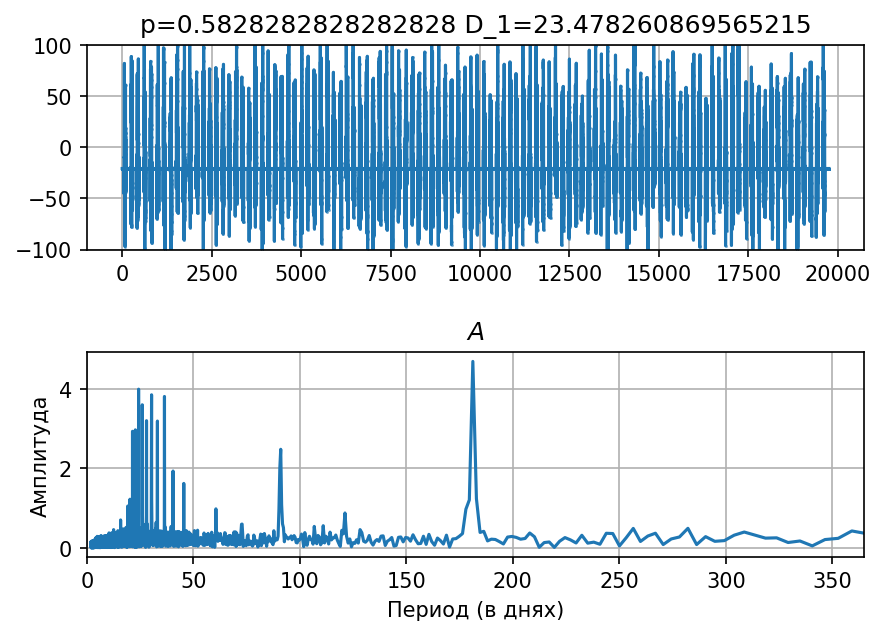

<Figure size 1224x360 with 0 Axes>

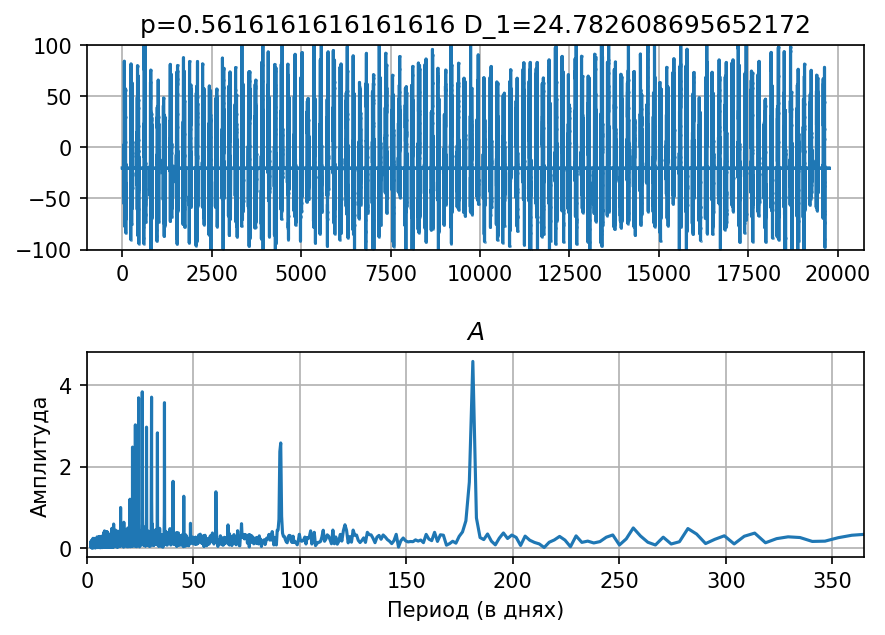

<Figure size 1224x360 with 0 Axes>

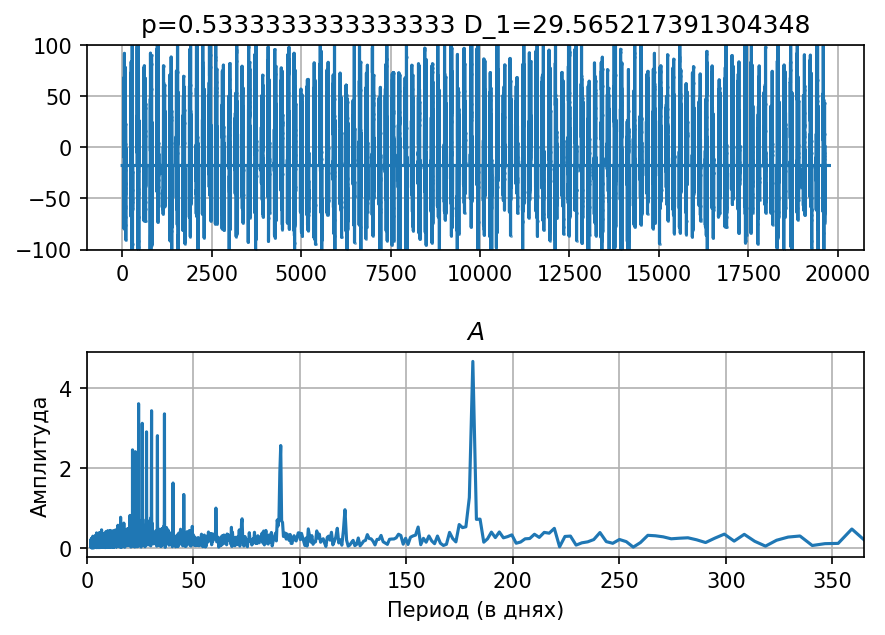

<Figure size 1224x360 with 0 Axes>

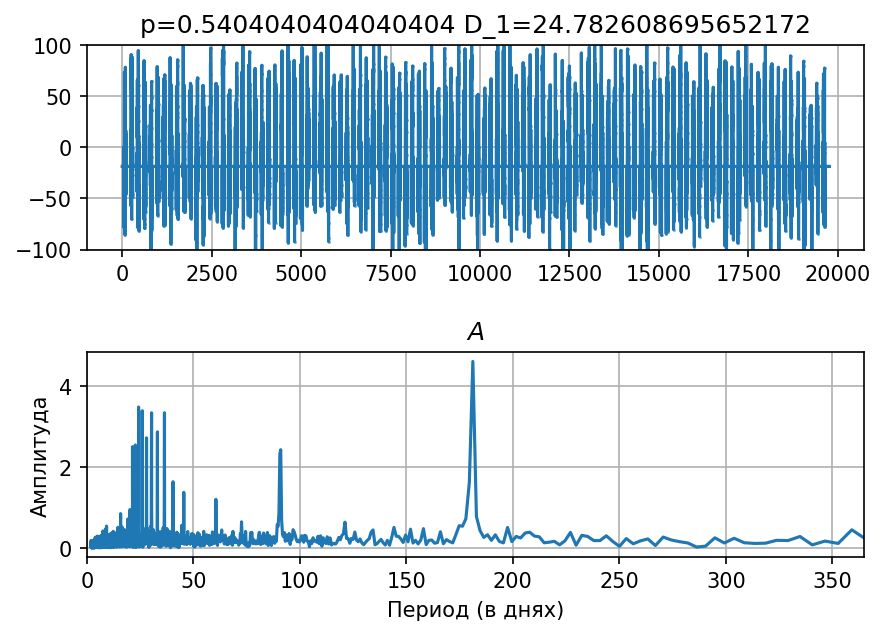

<Figure size 1224x360 with 0 Axes>

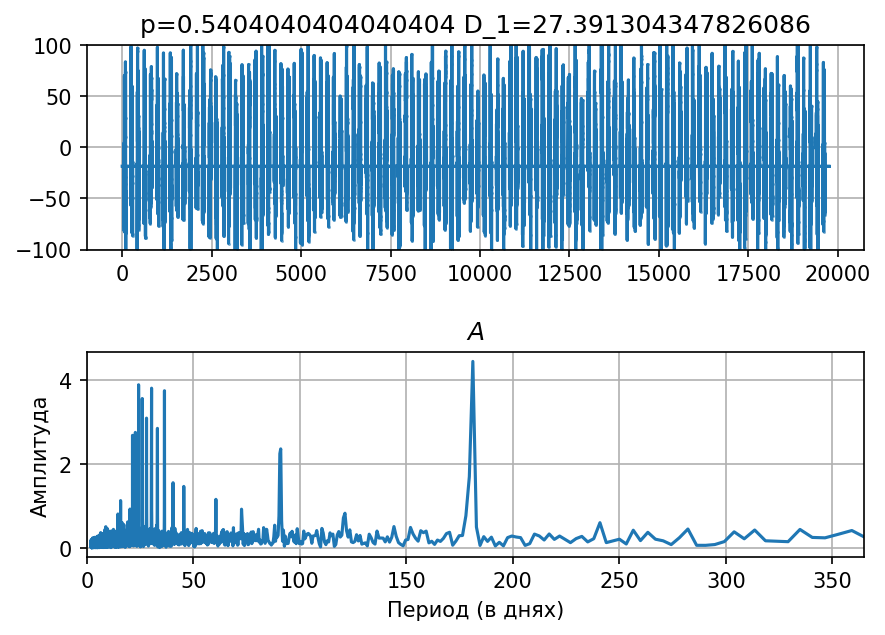

<Figure size 1224x360 with 0 Axes>

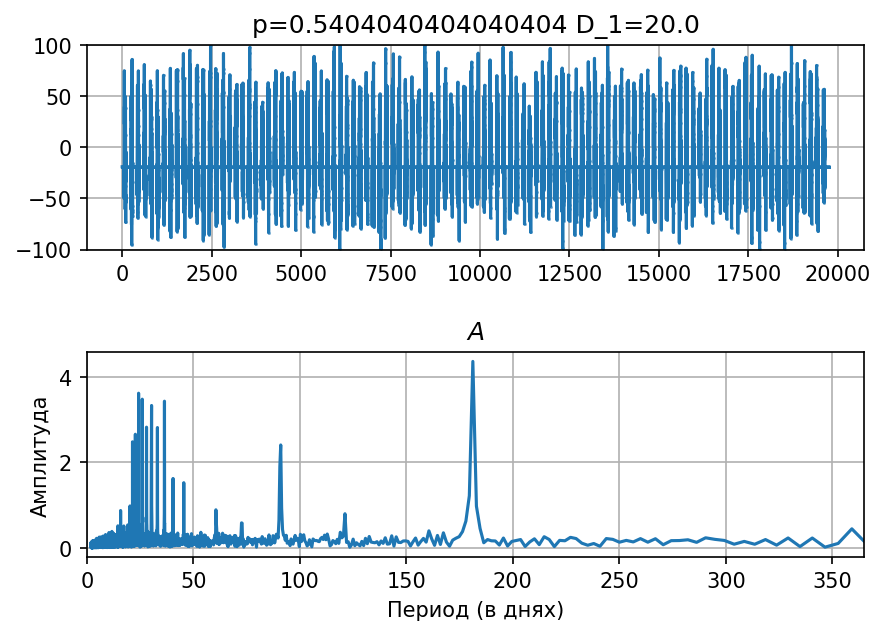

<Figure size 1224x360 with 0 Axes>

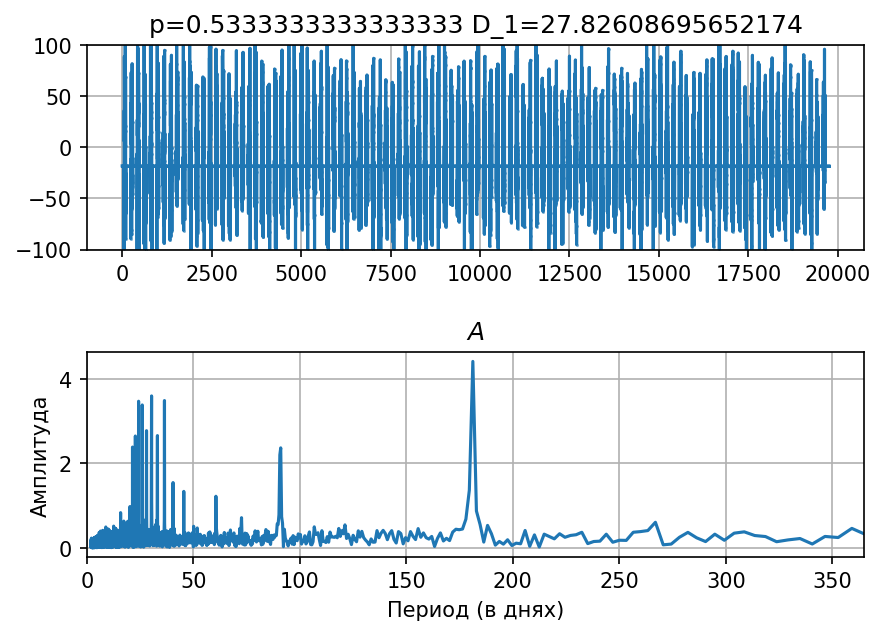

In [25]:
b_2 = -12.2626
d_2 = 19.1048
a_sin = 20
delta = 30
arr_top = top.head(10).values
Dst_generated = []
for x in arr_top:
    Dst_generated.append(imitate_Dst(delta=delta, T=27, p=x[0], to_smooth=True, D_1=x[1], B_2=b_2, D_2=d_2, A_sin=a_sin))
    name = "p="+str(x[0])+" D_1="+str(x[1])
    mfft2(arr=Dst_generated[-1], draw=True, x2=365, name=name)

In [26]:
p_mean = np.mean(top.head(10)['p'])
d1_mean = np.mean(top.head(10)['D1'])
print('mean p =', p_mean)
print('mean d1 =', d1_mean)

mean p = 0.551010101010101
mean d1 = 24.73913043478261


In [27]:
def retrieve_energy(ddata, draw=False):
    en1s = []
    en2s = []
    rels = []
    for i in range(73):
        filt(ddata, 1 + i * 5, 30)
        en1, en2, rel, _ = mFFT(ddata["filted"], draw = False, x1 = 20, x2 = 40, norm = ddata["filt"].sum(), energy = True)
        en1s.append(en1)
        en2s.append(en2)
        rels.append(rel)
    if draw:
        plt.plot( np.arange(1, 13.1, 1 / 6), en1s)
        plt.xlabel("month")
        plt.ylabel("27 days energy")
        plt.title("energy change")
        plt.show()
    return (max(en1s[:37]), min(en1s[20:50]), max(en1s[37:]))
    

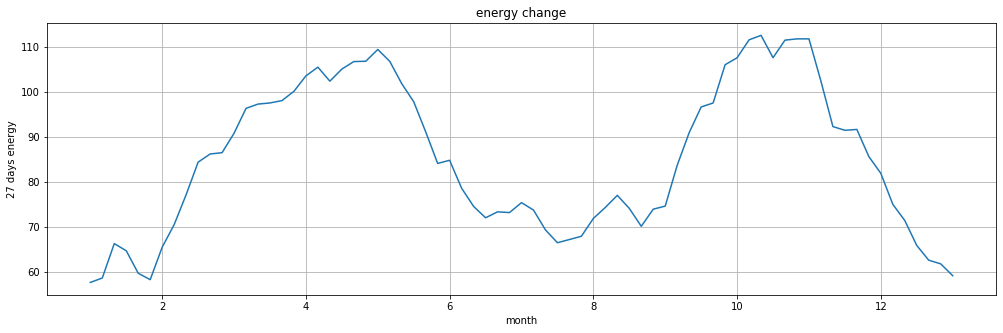

In [28]:
target = retrieve_energy(data, draw=True)

def get_error_sin(arr):
    df = pd.DataFrame(arr, columns=['Dst'])
    df['Day'] = np.arange(0, len(arr))
    current = retrieve_energy(df, draw=False)
    return (target[0] - current[0])**2 + (target[2] - current[1])**2 + (target[2] - current[2])**2

def get_errors_sin(b_2=-12.2626,  d_2=19.1048, a_sin=20, delta=30):
    from sklearn.metrics import mean_squared_error
    ps = np.linspace(0.3, 1, 50) # p
    ds = np.linspace(0, 30, 20) # стандатное отклонение синуса
    results = []
    # def imitate_Dst(delta=45, T=27, p=1, A_sin=1, to_smooth=False, D_1=1, B_2=1, D_2=1):
    for p in ps:
        for d_1 in ds:
            gen_data = imitate_Dst(delta=delta, T=27, p=p, A_sin=a_sin, to_smooth=True, D_1=d_1, B_2=b_2, D_2=d_2, only_sin=True)
            error = get_error_sin(gen_data[1:])
            results.append((p, d_1, error))
    return results

def get_top_errors_sin(b_2=-12.2626,  d_2=19.1048, a_sin=20, delta=30):
    results = get_errors_sin(b_2, d_2, a_sin, delta)
    top_results = sorted(results, key=lambda x: x[2])
    df_errors = pd.DataFrame(top_results, columns=["p", "D1", "error"])
    sorted_errors = df_errors.sort_values(by='error')
    sorted_errors.head
    return sorted_errors


In [29]:
top_sin = get_top_errors_sin()
top_sin

,p,D1,error
0,0.300000,0.000000,1.274406e+04
1,0.300000,1.578947,1.277155e+04
2,0.300000,3.157895,1.279303e+04
3,0.314286,1.578947,1.280230e+04
4,0.300000,4.736842,1.281874e+04
...,...,...,...
995,1.000000,6.315789,1.264959e+07
996,1.000000,25.263158,1.472613e+07
997,1.000000,22.105263,1.593673e+07
998,1.000000,30.000000,1.711536e+07


<Figure size 1224x360 with 0 Axes>

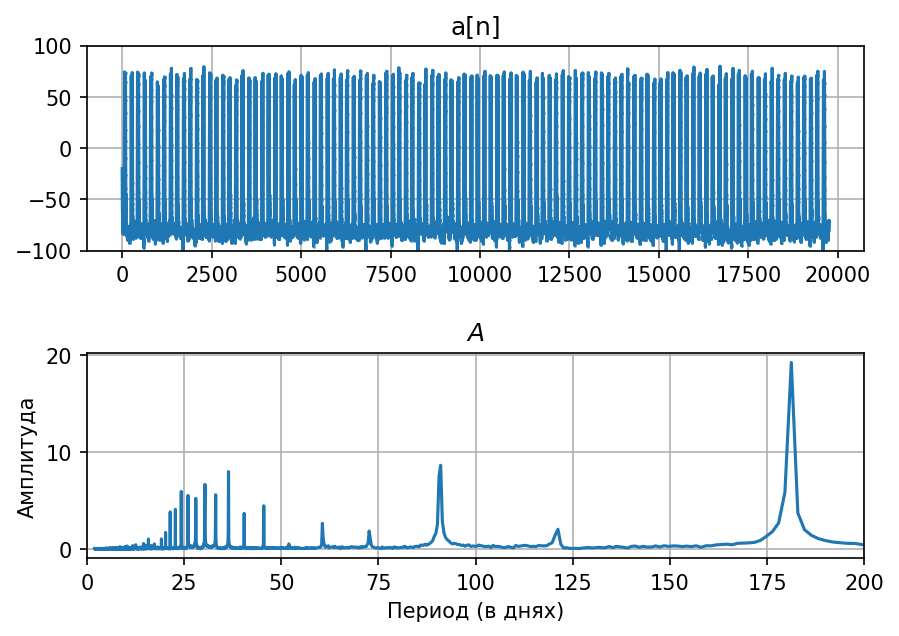

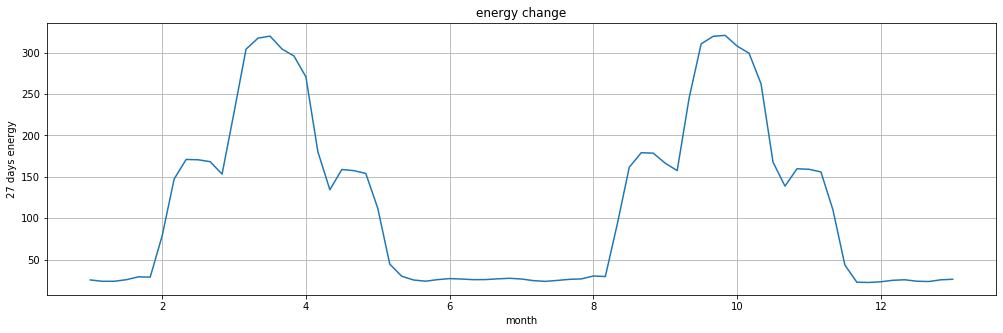

(319.9874365636814, 23.67736230397469, 320.8686029229553)

In [30]:
b_2 = -12.2626
d_2 = 2
a_sin = 18.5
a_sin2 = 8
delta = 30
d_1 = 2
gend = imitate_Dst(delta=delta, T=27, p=0.85, A_sin=a_sin, A_sin2=a_sin2, to_smooth=False, D_1=d_1, B_2=b_2, D_2=d_2, only_sin=False)
mfft2(gend, draw=True, x1=0, x2=200)
arrx = pd.DataFrame(gend, columns=['Dst'])
arrx['Day'] = np.arange(0, len(arrx['Dst']))
retrieve_energy(arrx, draw=True)

In [31]:
df = pd.DataFrame(gend, columns=['Dst'])
arrx['DOY'] = np.arange(0, len(arrx['Dst']))
df.to_csv('verify.csv')

<Figure size 1224x360 with 0 Axes>

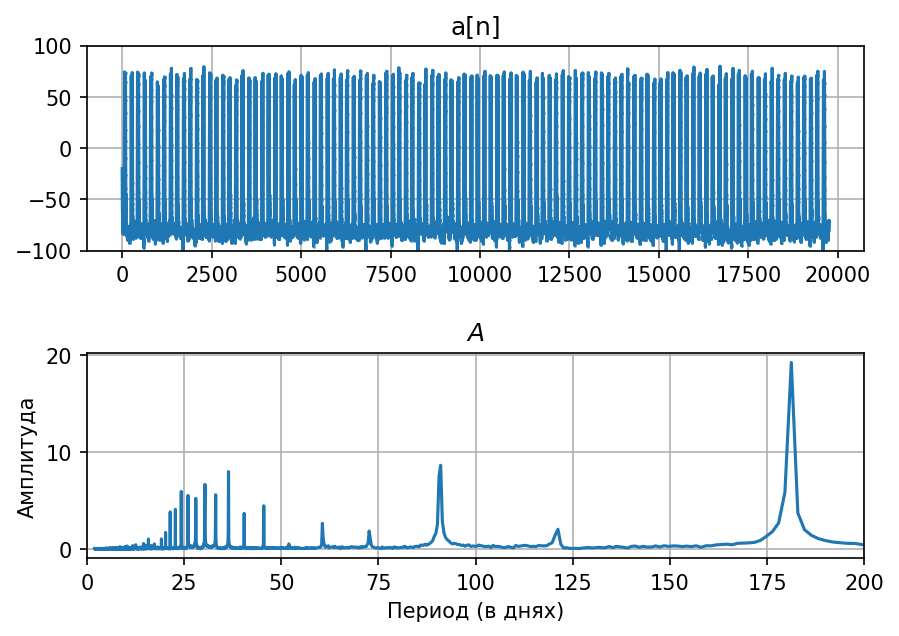

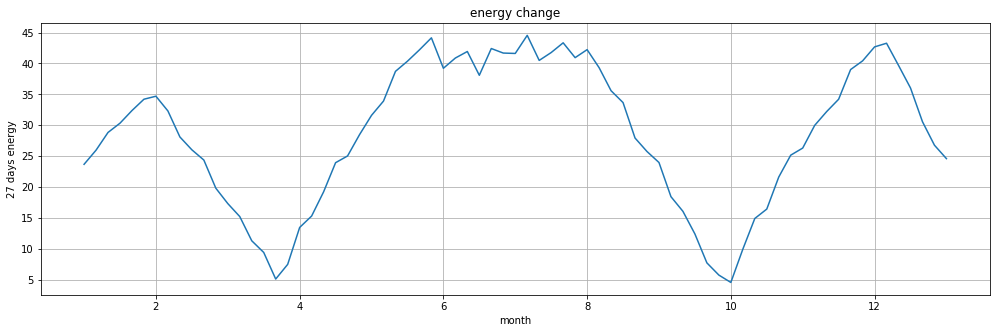

(44.14721109865489, 18.423750927668106, 44.54902175981766)

In [32]:
b_2 = -1
d_2 = 2
a_sin = 0
a_sin2 = 2
delta = 30
d_1 = 0
gend2 = imitate_Dst(delta=delta, T=27, p=0.85, A_sin=a_sin, A_sin2=a_sin2, to_smooth=False, D_1=d_1, B_2=b_2, D_2=d_2, only_sin=True)
mfft2(gend, draw=True, x1 = 0, x2=200)
arrx2 = pd.DataFrame(gend2, columns=['Dst'])
arrx2['Day'] = np.arange(0, len(arrx2['Dst']))
retrieve_energy(arrx2, draw=True)